## Project Proposal: Risk Classification for Firms Utilizing Historical Audit Risk Scores and Discrepancies using KNN Classification

### Group 28 Members: Michael Ly, Avery Ma and Veer Arora



## Introduction

For businesses around the world, there exists a risk of the business working against the best interest of their stakeholders by misrepresenting financial information due to lack of financial controls or auditing procedures. The practice of auditing businesses require extensive analysis and thorough investigation by accounting and auditing firms. Because there are so many businesses, there are not always enough resources to determine what business would make an appropriate target for an auditing firm to audit.

Our hope is that we can create a classfication model that can help auditing firms determine what business would be considered a risk to financial mismanagement and classify them accordingly as targets of future audits. 

Given a data set of characteristics of firms of different sectors, historical mistatement scores, and different risk scores would we be able to create a K - Nearest Neighbor classification model that can accurately identify risk firms? And will it be reliable and accurate enough for us to classify whether a firm is Risk firm or a Non-Risk firm working in the best interest of its stakeholders?

Our data set examines the present and historical risk factors and financial discrepancy scores for the determining the audit risk score and concludes whether firm is classified under Risk (1) or No Risk (0).

Our data set is drawn from the UCI Machine Learning Repository, with its origins from Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64. https://archive.ics.uci.edu/ml/datasets/Audit+Data

There are many different variables described in the original audit risk dataset such as analysis scores completed by the original authors that we have decided to remove because they have not been defined.

The original description of the dataset reports that after an in-depth interview with auditors, important risk factors have been evaluated and probability of existence of these risk factors have been calculated using their present and past records.

We have decided to include the variables listed to investigate as possible predictors for our model.

* Sector Score: Historical risk score value of the target-unit
* Location ID: Unique ID of the city/province.
* Para A value: Discrepancy found in the planned-expenditure of inspection
* Para B value: Discrepancy found in the unplanned-expenditure of inspection
* Numbers: Historical discrepancy score.
* Total: Total amount of discrepancy found in other reports Rs (PARA_A + PARA_B).
* Money Value: Amount of money involved in misstatements in the past audits.
* District Loss: Score based on amount of loss suffered by the district
* History: Average historical loss suffered by firm in the last 10 years.
* Inherent Risk: The risk posed by an error or omission in a financial statement due to a factor other than a failure of internal control.
* Control Risk: The chance of a material misstatement in a company’s financial statements because there aren’t any relevant internal controls to mitigate a particular risk or the internal controls in place malfunctioned.
* Detection Risk: The chance that an auditor will fail to find material misstatements that exist in an entity's financial statements.
* Audit Risk: The risk that the auditor expresses an inappropriate audit opinion when the financial statements are materially misstated
* Risk: Classifies whether a firm is considered Risk (1) or No Risk (2)

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
audit_risk_data <- read_csv("https://raw.githubusercontent.com/DicedOnion/dsci-100-2022w1-group-28/main/data/audit_risk.csv")
audit_risk_data <- mutate(audit_risk_data, Risk = as_factor(Risk))

audit_split <- initial_split(audit_risk_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


* We will be working with Risk as our factor so we convert it accordingly before we split our data set.

* We split our data into training and testing data, with 75% of the dataset representing the training data and the remaining 25% as the testing data.

In [3]:
num_obs <- nrow(audit_training)
audit_training |> 
    group_by(Risk) |> 
    summarize(
        count = n(),
        percentage = n()/num_obs * 100)

Risk,count,percentage
<fct>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


* We then examine the number and percentage between the different levels of our factor within our training data set to see if each class is reasonably represented. We conclude that each class is reasonably represented in our training data set.

In [4]:
audit_training_select <- audit_training |> 
    select(Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers, Money_Value, District_Loss,History, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk, Risk) 
audit_training_select

Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District_Loss,History,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0.51,0.23,0.74,5,0.00,2,0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.08,0.08,5,0.00,2,0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.83,0.83,5,2.95,2,0,2.156,0.4,0.5,0.4312,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,2,1.06,0.63,1.69,5,0.90,6,0,2.930,1.2,0.5,1.7580,1
55.57,32,0.00,8.49,8.49,5,0.43,2,0,6.580,0.4,0.5,1.3160,1
55.57,13,1.06,1.60,2.66,5,16.09,2,0,12.118,0.4,0.5,2.4236,1


* We then select our variables of interest that have been defined to explore as possible predictors.

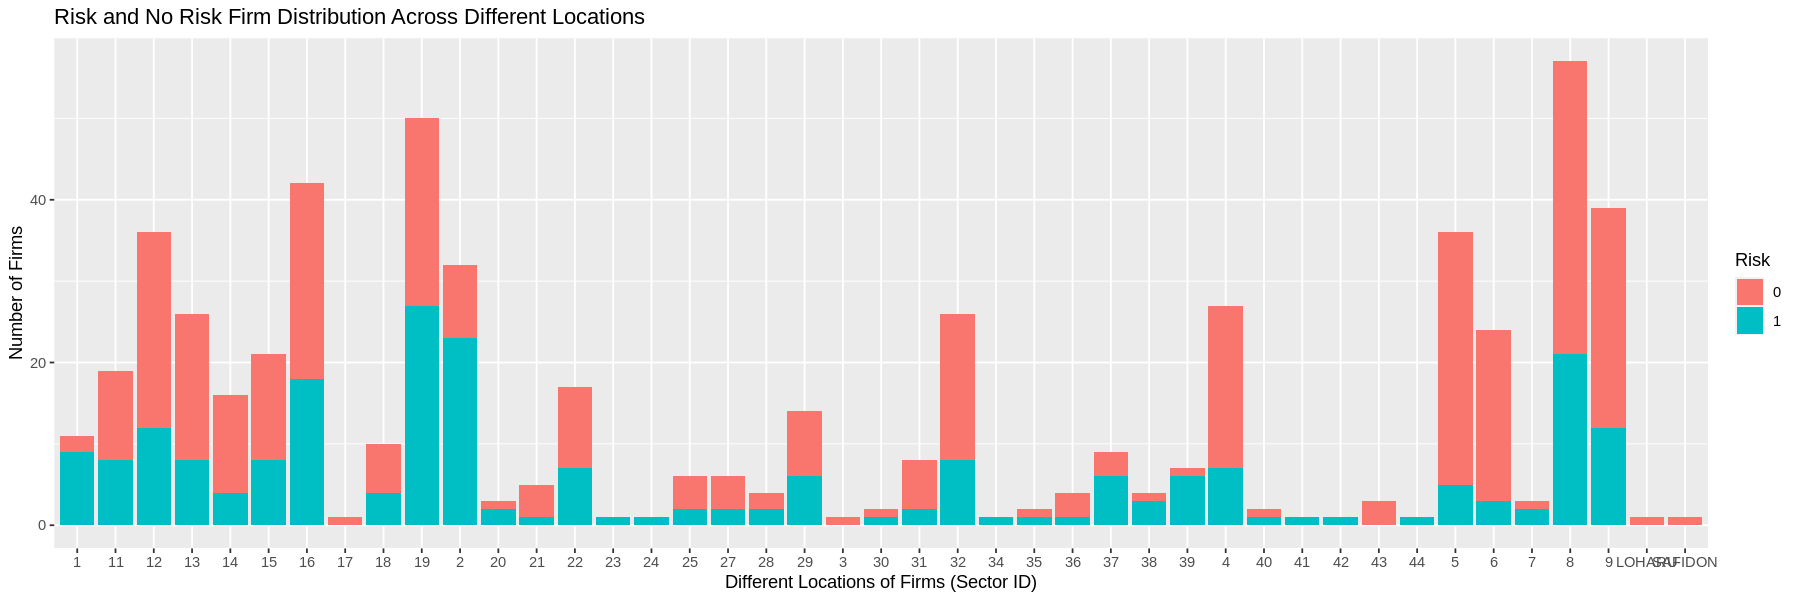

In [5]:
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(audit_training_select, aes(x= LOCATION_ID, fill = Risk)) +
    geom_bar() + 
    xlab("Different Locations of Firms (Sector ID)") +
    ylab("Number of Firms") +
    ggtitle("Risk and No Risk Firm Distribution Across Different Locations")

* We look at the class of the firms that are distributed across the different locations by location ID to see if location will make a good predictor for determining whether a firm is Risk or No Risk. Based on the visual distribution of Risk and No Risk across the different locations we can see that there are some locations that have Risk firms only and other that have No Risk firms only. However, there are also many locations that seem to equally represent both risk categories. Therefore, it would be difficult to really use location alone as a predictor for our model.

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”


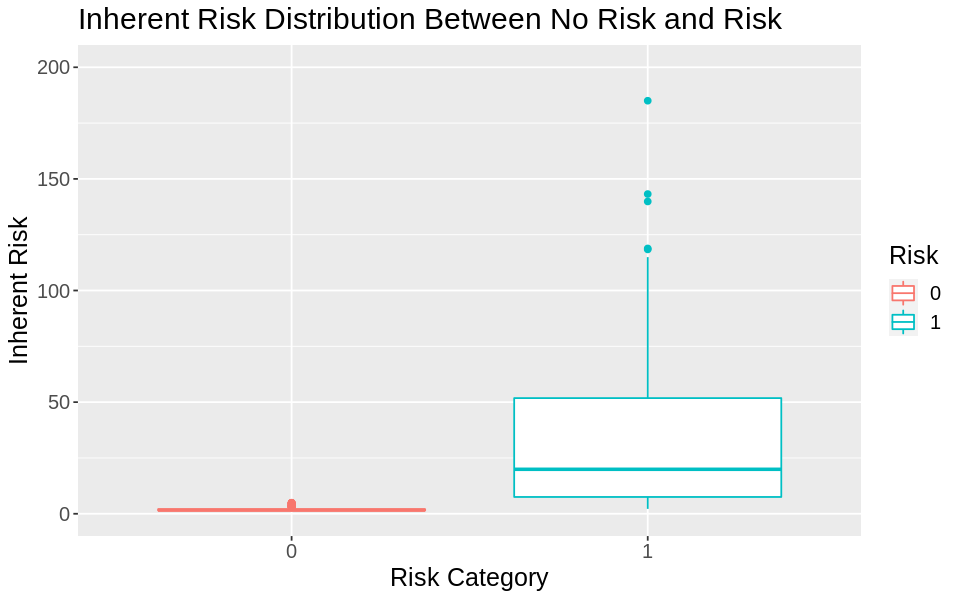

In [6]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Inherent_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 200)) +
  labs(x = "Risk Category", y = "Inherent Risk") +
  ggtitle("Inherent Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))


* We used a box plot to represent the distribution of inherent risk across both Risk classes. Inherent risk is defined as the risk posed by an error or omission in a financial statement due to a factor other than a failure of internal control. We can see evidently see that firms that are classified as Risk have a far greater inherent risk score than firms with no risk according to our boxplot comparing the distribution of the two classes. Both the median and the interquartile ranges do not appear to overlap indicating a difference between the two groups. This would make inherent risk a good reliable predictor for our model.

Warning message:
“Removed 20 rows containing non-finite values (stat_boxplot).”


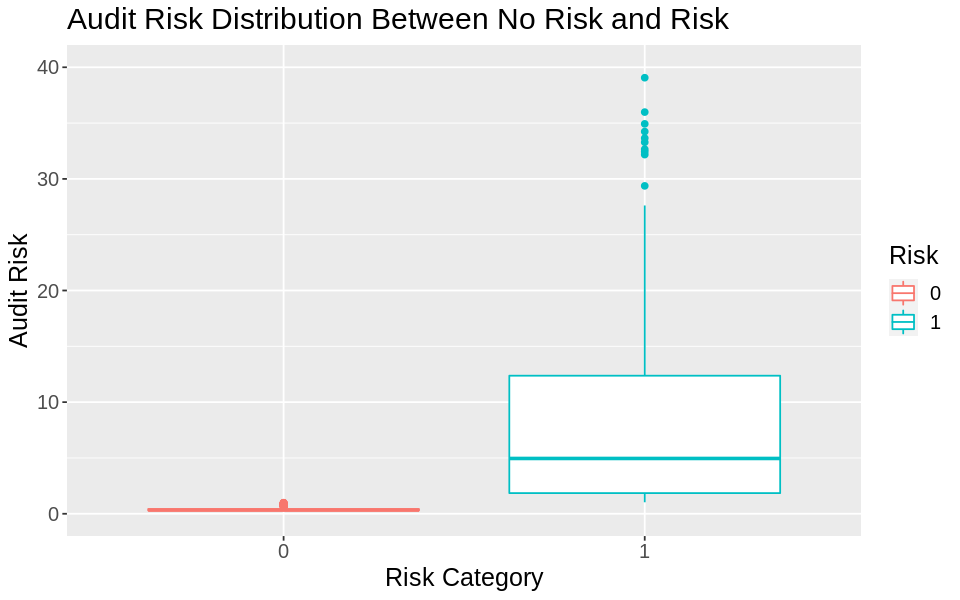

In [7]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Audit_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 40)) +
  labs(x = "Risk Category", y = "Audit Risk") +
  ggtitle("Audit Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* We use a box plot to represent the distribution of Audit Risk across our two classes. In general, audit risk is defined as the risk that the auditor expresses an inappropriate audit opinion when the financial statements are materially misstated. Looking at the box plot distributions we can see that Risk class firms have a significantly higher distribution of audit risk score than No Risk firms. Both the median and the interquartile ranges do not appear to overlap indicating a difference between the two groups. This would make audit risk a good reliable predictor to utilize in our classification model.

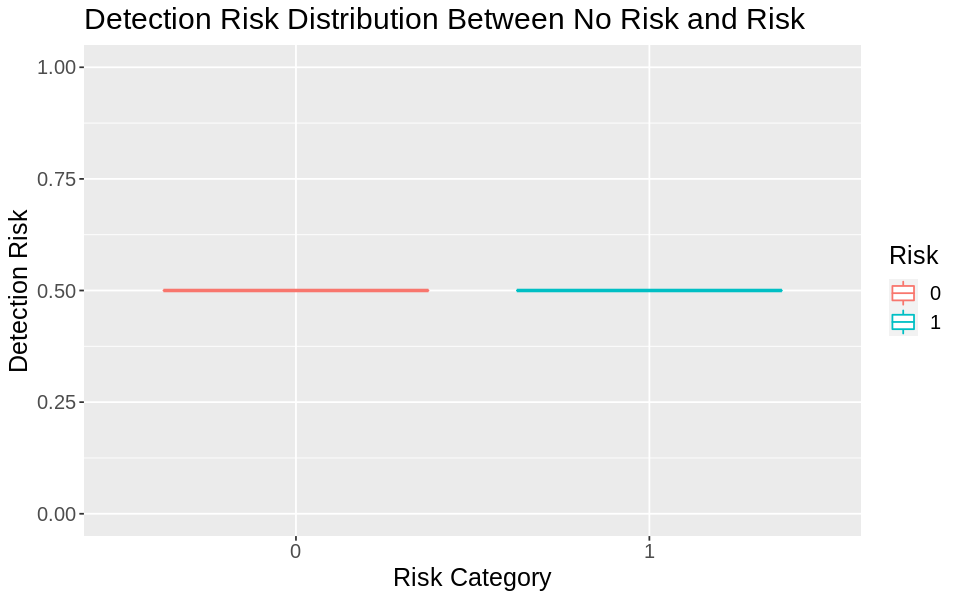

In [8]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Detection_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 1)) +
  labs(x = "Risk Category", y = "Detection Risk") +
  ggtitle("Detection Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots to compare the distribution of detection risk between Risk and No Risk. Detection risk is defined as the chance that an auditor will fail to find material misstatements that exist in an entity's financial statements. Comparing both box plots, we can see that detection risk does not appear to be different across the two risk categories. This would not make detection risk a good predictor for our model.

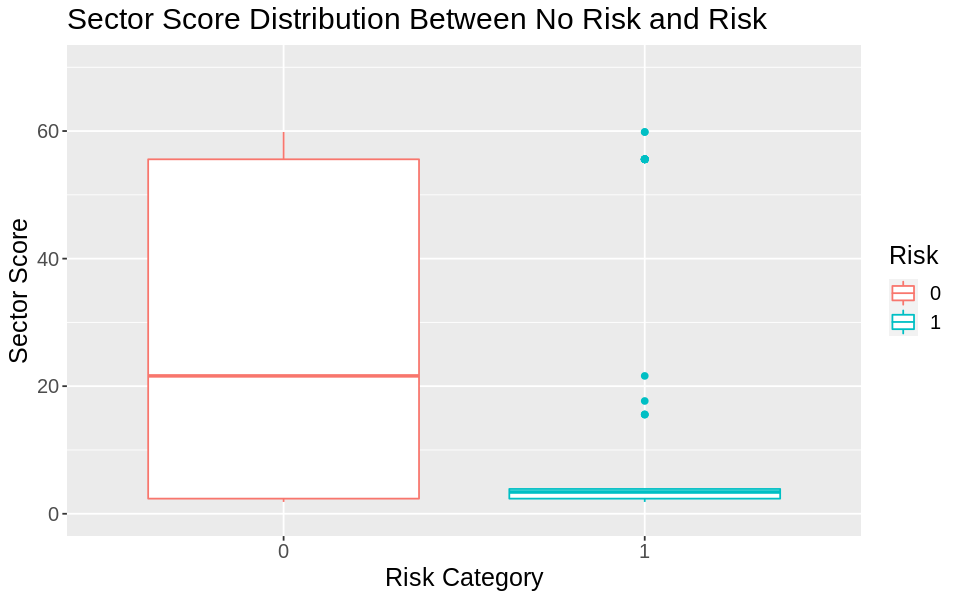

In [9]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y = Sector_score, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 70)) +
  labs(x = "Risk Category", y = "Sector Score") +
  ggtitle("Sector Score Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of sector score between Risk and No Risk. The sector score is defined as the historical risk score value of the target-unit according to an original the data set description. Comparing both box plots, we can see that both boxes have overlapping ranges, but we can also note that the no risk class seems to have an evidently higher sector score median than the risk class.  The difference in the distribution of sectors scores between the two classes may make this a predictor we can use for our model.

Warning message:
“Removed 21 rows containing non-finite values (stat_boxplot).”


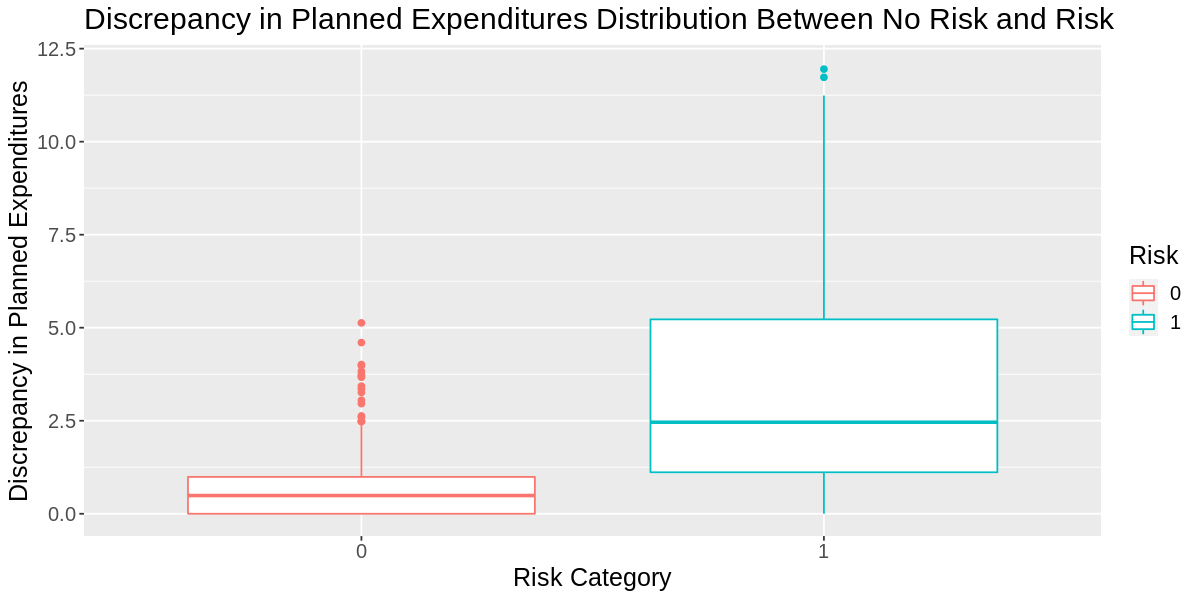

In [10]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y = PARA_A, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 12)) +
  labs(x = "Risk Category", y = "Discrepancy in Planned Expenditures") +
  ggtitle("Discrepancy in Planned Expenditures Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of discrepancies found in planned expenditure reports between Risk and No Risk. The median and interquartile ranges for both box plots do not appear to overlap, and show that for the Risk group, the discrepancies found in planned expenditures are evidently higher than those found in the No Risk group. This difference makes discrepancies found in planned expenditure reports a good predictor we can use in our model.

Warning message:
“Removed 94 rows containing non-finite values (stat_boxplot).”


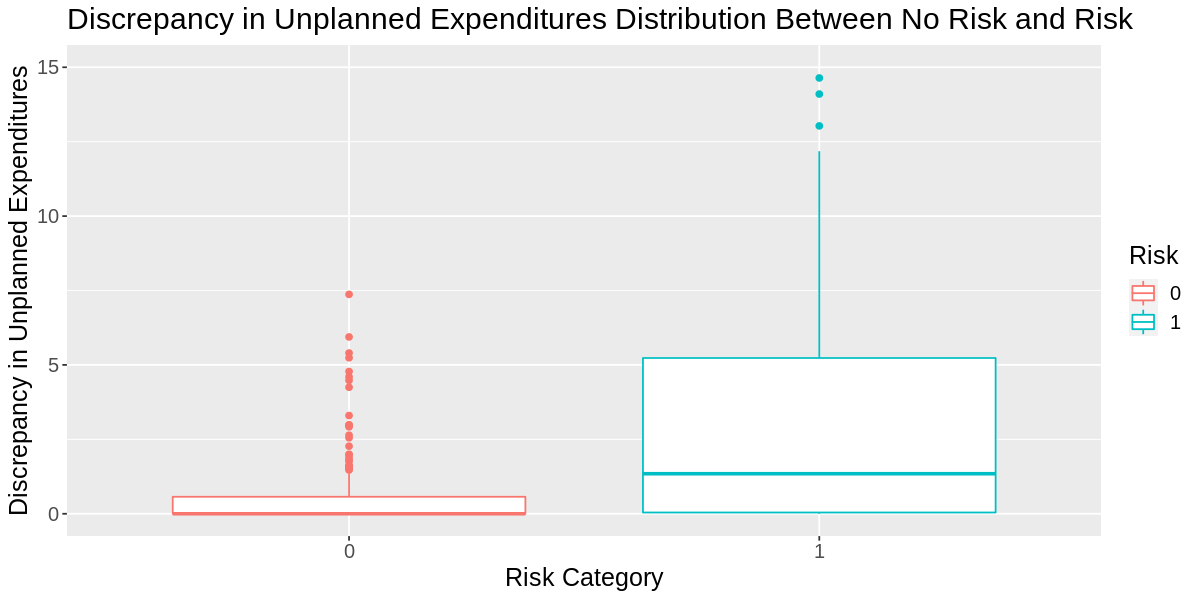

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y = PARA_B, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 15)) +
  labs(x = "Risk Category", y = "Discrepancy in Unplanned Expenditures") +
  ggtitle("Discrepancy in Unplanned Expenditures Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of discrepancies found in unplanned expenditures reports between Risk and No Risk. It appears that the median for the Risk group is higher for unplanned expenditures discrepancies than the No Risk group which may indicate a difference between the two groups. The difference in the distribution of unplanned expenditures between the two classes may make this a predictor we can use for our model, however it does not seem to indicate as strong of a difference as compared to discrepancies in planned expenditures.

Warning message:
“Removed 67 rows containing non-finite values (stat_boxplot).”


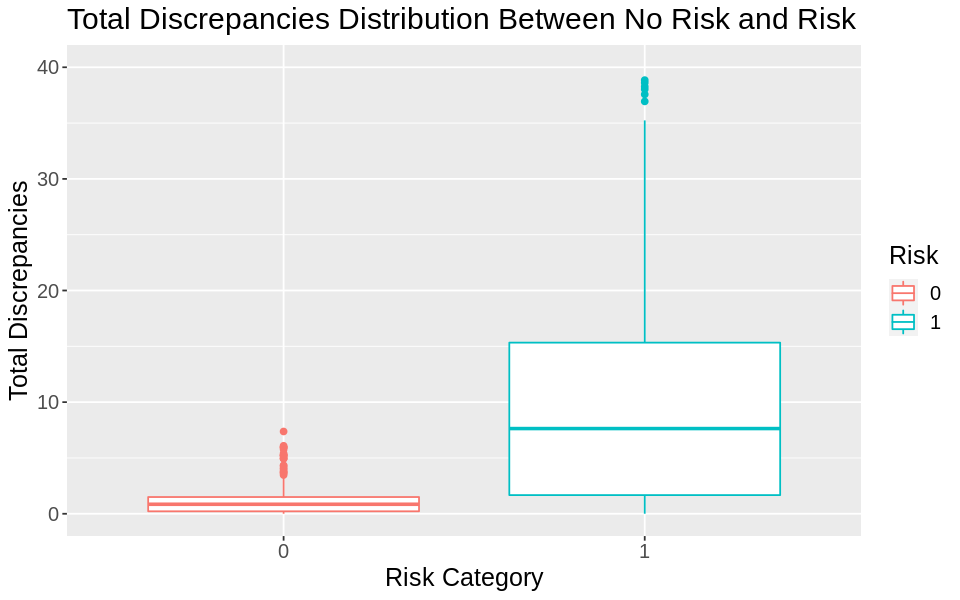

In [12]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=TOTAL, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 40)) +
  labs(x = "Risk Category", y = "Total Discrepancies") +
  ggtitle("Total Discrepancies Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of total discrepancies (combination of discrepancies found in planned and unplanned reports) between Risk and No Risk. When comparing the total discrepancies across both groups we can see that there is a clear difference between them. There appears to be greater total discrepancies found in the Risk class than that found in the No Risk class as represented by the higher median in the Risk box plot and the non-overlapping interquartile ranges. We can consider using this as a predictor for our model given that it shows this difference.

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


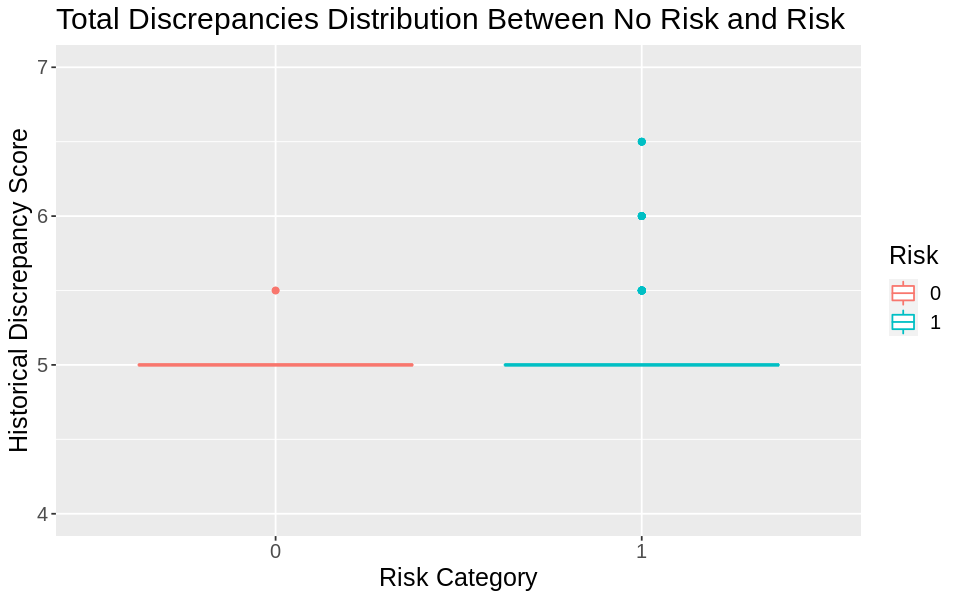

In [13]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=numbers, color = Risk)) +
  geom_boxplot() +
  ylim(c(4, 7)) +
  labs(x = "Risk Category", y = "Historical Discrepancy Score") +
  ggtitle("Total Discrepancies Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of historical discrepancy score in the data set between the two groups. The box plots do not show any interesting difference between the two groups. This would not be a predictor we would use for our model.

Warning message:
“Removed 26 rows containing non-finite values (stat_boxplot).”


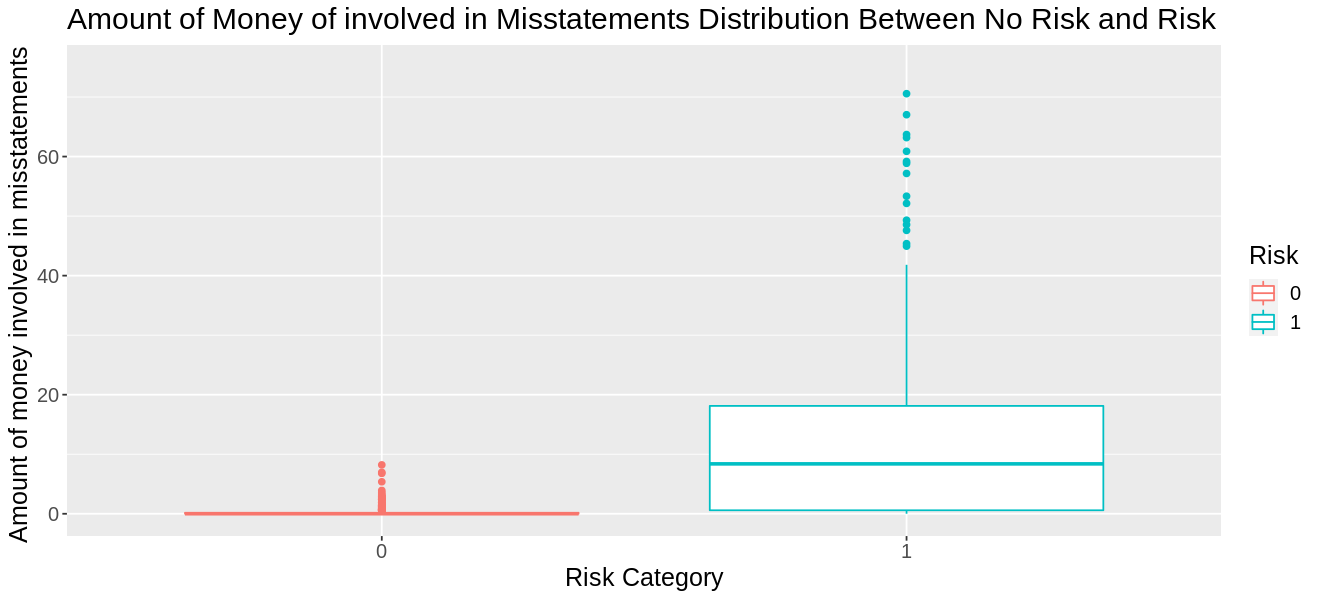

In [14]:
options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Money_Value, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 75)) +
  labs(x = "Risk Category", y = "Amount of money involved in misstatements ") +
  ggtitle("Amount of Money of involved in Misstatements Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of money involved in misstatements between Risk and No Risk. It is clear that the Risk group has a higher amount of money involved in misstatements than the No Risk group as represented by the median of both box plots. This is a predictor we can consider using for our model given this difference.

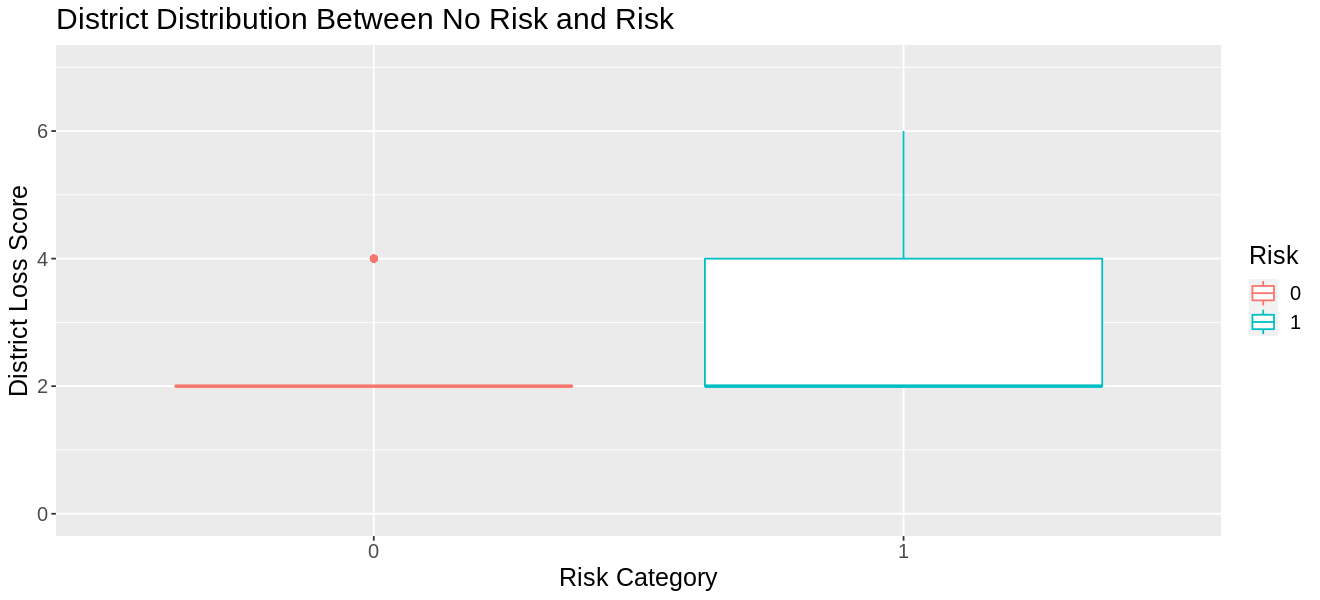

In [15]:
options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=District_Loss, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 7)) +
  labs(x = "Risk Category", y = "District Loss Score") +
  ggtitle("District Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of District Loss Score between Risk and No Risk. Both the median for both plots seem to be the same with the Risk group having a larger interquartile range. This would not make for a good predictor for our model since it does not show a difference between Risk and No Risk.

Warning message:
“Removed 40 rows containing non-finite values (stat_boxplot).”


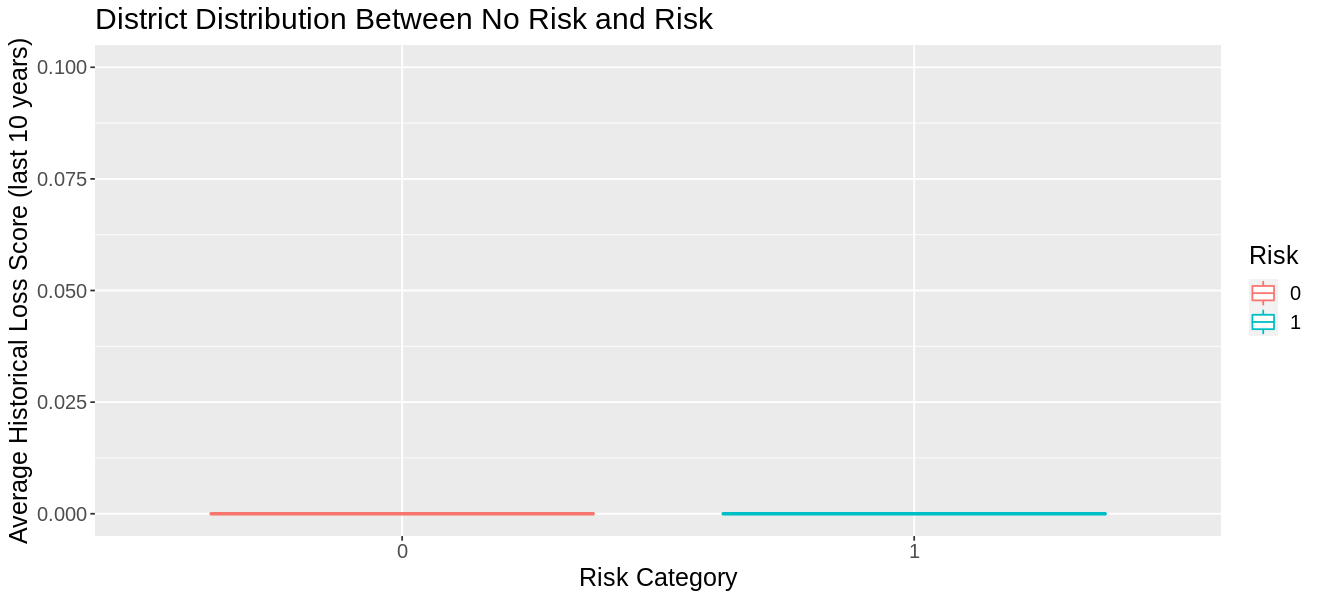

In [16]:
options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=History, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 0.1)) +
  labs(x = "Risk Category", y = "Average Historical Loss Score (last 10 years)") +
  ggtitle("District Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of average historical loss score between the two groups. Both groups appear to have the score at zero, which rules it out as a useful predictor.

Warning message:
“Removed 51 rows containing missing values (geom_point).”


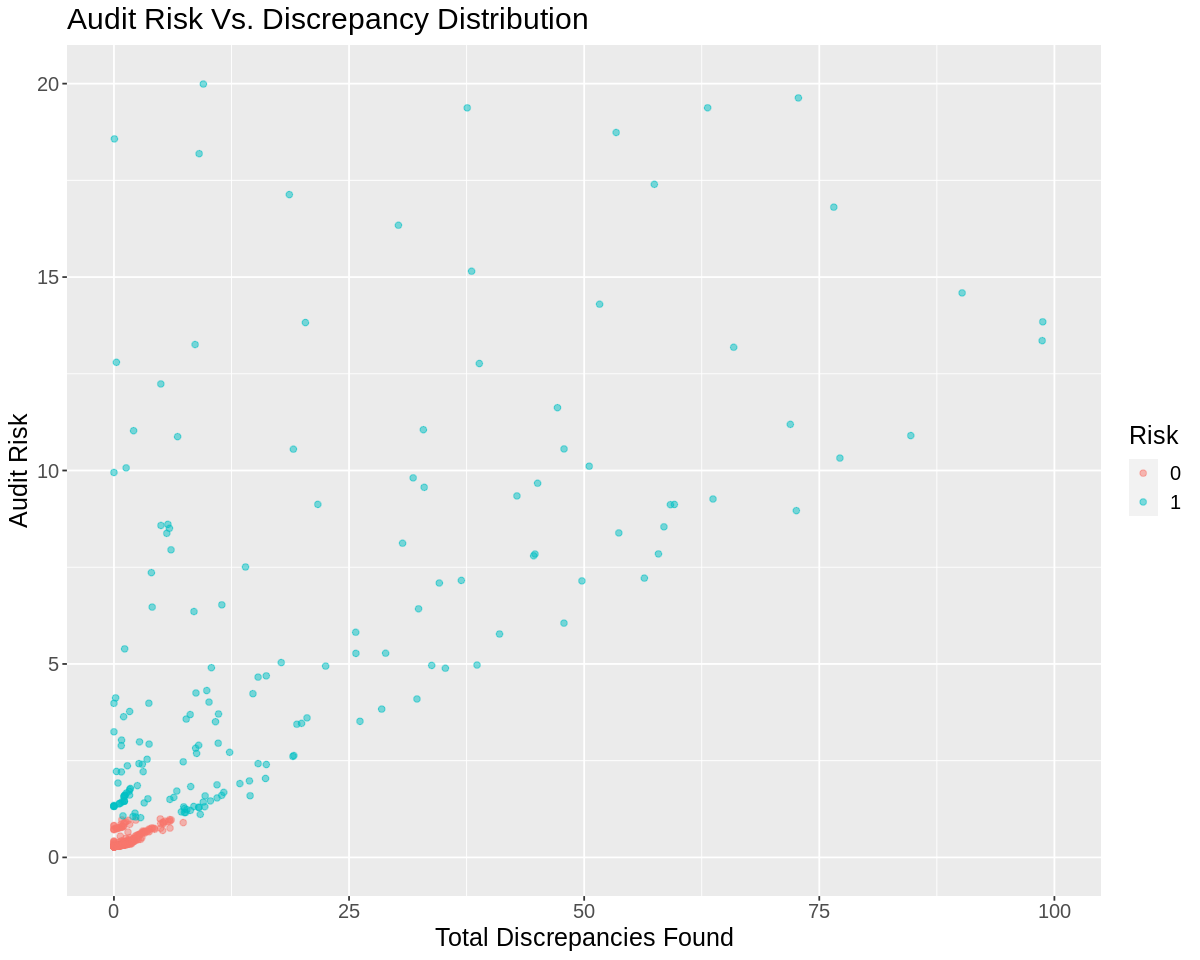

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8)

discrepancy_plot <- audit_training_select |>
ggplot(aes(x = TOTAL, y = Audit_Risk, color = Risk)) +
geom_point(alpha = 0.5) +
    xlab("Total Discrepancies Found") +
    ylab("Audit Risk") +
    labs(color = "Risk") +
    ggtitle("Audit Risk Vs. Discrepancy Distribution") +
    theme(text = element_text(size = 15))+
    ylim(c(0, 20)) +
    xlim(c(0,100))


discrepancy_plot

* This scatter plot is to determine whether there is any clustering or relationship between Total Number of Discrepancies found and Audit Risk Score. We see that there is a clustering of No Risk near the lower left with Risk observations scattered above and to the right of the plot. Another observation is as total amount of discrepancies increase the audit risk score also increases as well. This shows that No Risk observations tend to have lower audit risk scores and lower total discrepancies.

## Methods
* Our exploratory analysis showed possible predictors we can use for our model: Inherent Risk, Audit Risk, Discrepancies in Planned Expenditures (PARA_A), Discrepancies in Unplanned Expenditures (PARA_B), Total Discrepancies, Money Value and Sector Score. 

* We will visualize our K-nearest Neighbor classification model using scatter plots to visualize the new observation and its distance from it neighbors and to determine appropriate fit.

## Expected Outcomes and Significance
* We hope to find that our classification model is able to reliably predict whether a firm is a Risk firm or a No Risk Firm. If this can be reliably achieved with a high level of accuracy it would allow for audit firms or governments to utilize this model to allow for more productive targeting of specific businesses or firms that have a high risk for financial mismanagement or fraud. 
* Since there can be many other indicators of financial fraud and risk used in business auditing practices, what other predictors can be used to create an even better model for classifying whether a firm should be considered a target for audit? And can it be generalized to different business areas in different parts of the world with different accounting practices?